### Notebook to the identification of infected and bystander cells using a logistic regression classifier 

- **Developed by**: Carlos Talavera-López Ph.D
- **Würzburg Institute for Systems Immunology & Faculty of Medicine, Julius-Maximilian-Universität Würzburg**
- v231212

### Import required modules

In [1]:
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from pywaffle import Waffle
from gprofiler import GProfiler
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.2
scanpy      1.9.5
-----
PIL                 10.0.0
asttokens           NA
backcall            0.2.0
certifi             2023.07.22
charset_normalizer  3.2.0
colorama            0.4.6
comm                0.1.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7.post1
decorator           5.1.1
exceptiongroup      1.1.3
executing           1.2.0
gprofiler           1.0.0
h5py                3.9.0
idna                3.4
igraph              0.10.8
importlib_resources NA
ipykernel           6.25.1
ipywidgets          8.1.0
jedi                0.19.0
joblib              1.3.2
kiwisolver          1.4.5
leidenalg           0.10.1
llvmlite            0.40.1
louvain             0.8.1
matplotlib          3.7.2
mpl_toolkits        NA
natsort             8.4.0
numba               0.57.1
numexpr             2.8.7
numpy               1.24.4
packaging           23.1
pandas              2.1.1
parso               0.8.3
patsy     

### Read in dataset

In [3]:
adata = sc.read_h5ad('../data/Marburg_cell_states_locked_ctl230901.raw.h5ad') 
adata

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels'
    var: 'mt', 'ribo'

### Identify viral genes and create label for them

In [4]:
viral_genes = [gene for gene in adata.var_names if 'NC_' in gene]
adata.obs['viral_counts'] = np.sum(adata[:, viral_genes].X, axis = 1)

/tmp/ipykernel_2921848/546386329.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_means = adata.obs.groupby('group')['viral_counts'].mean()
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


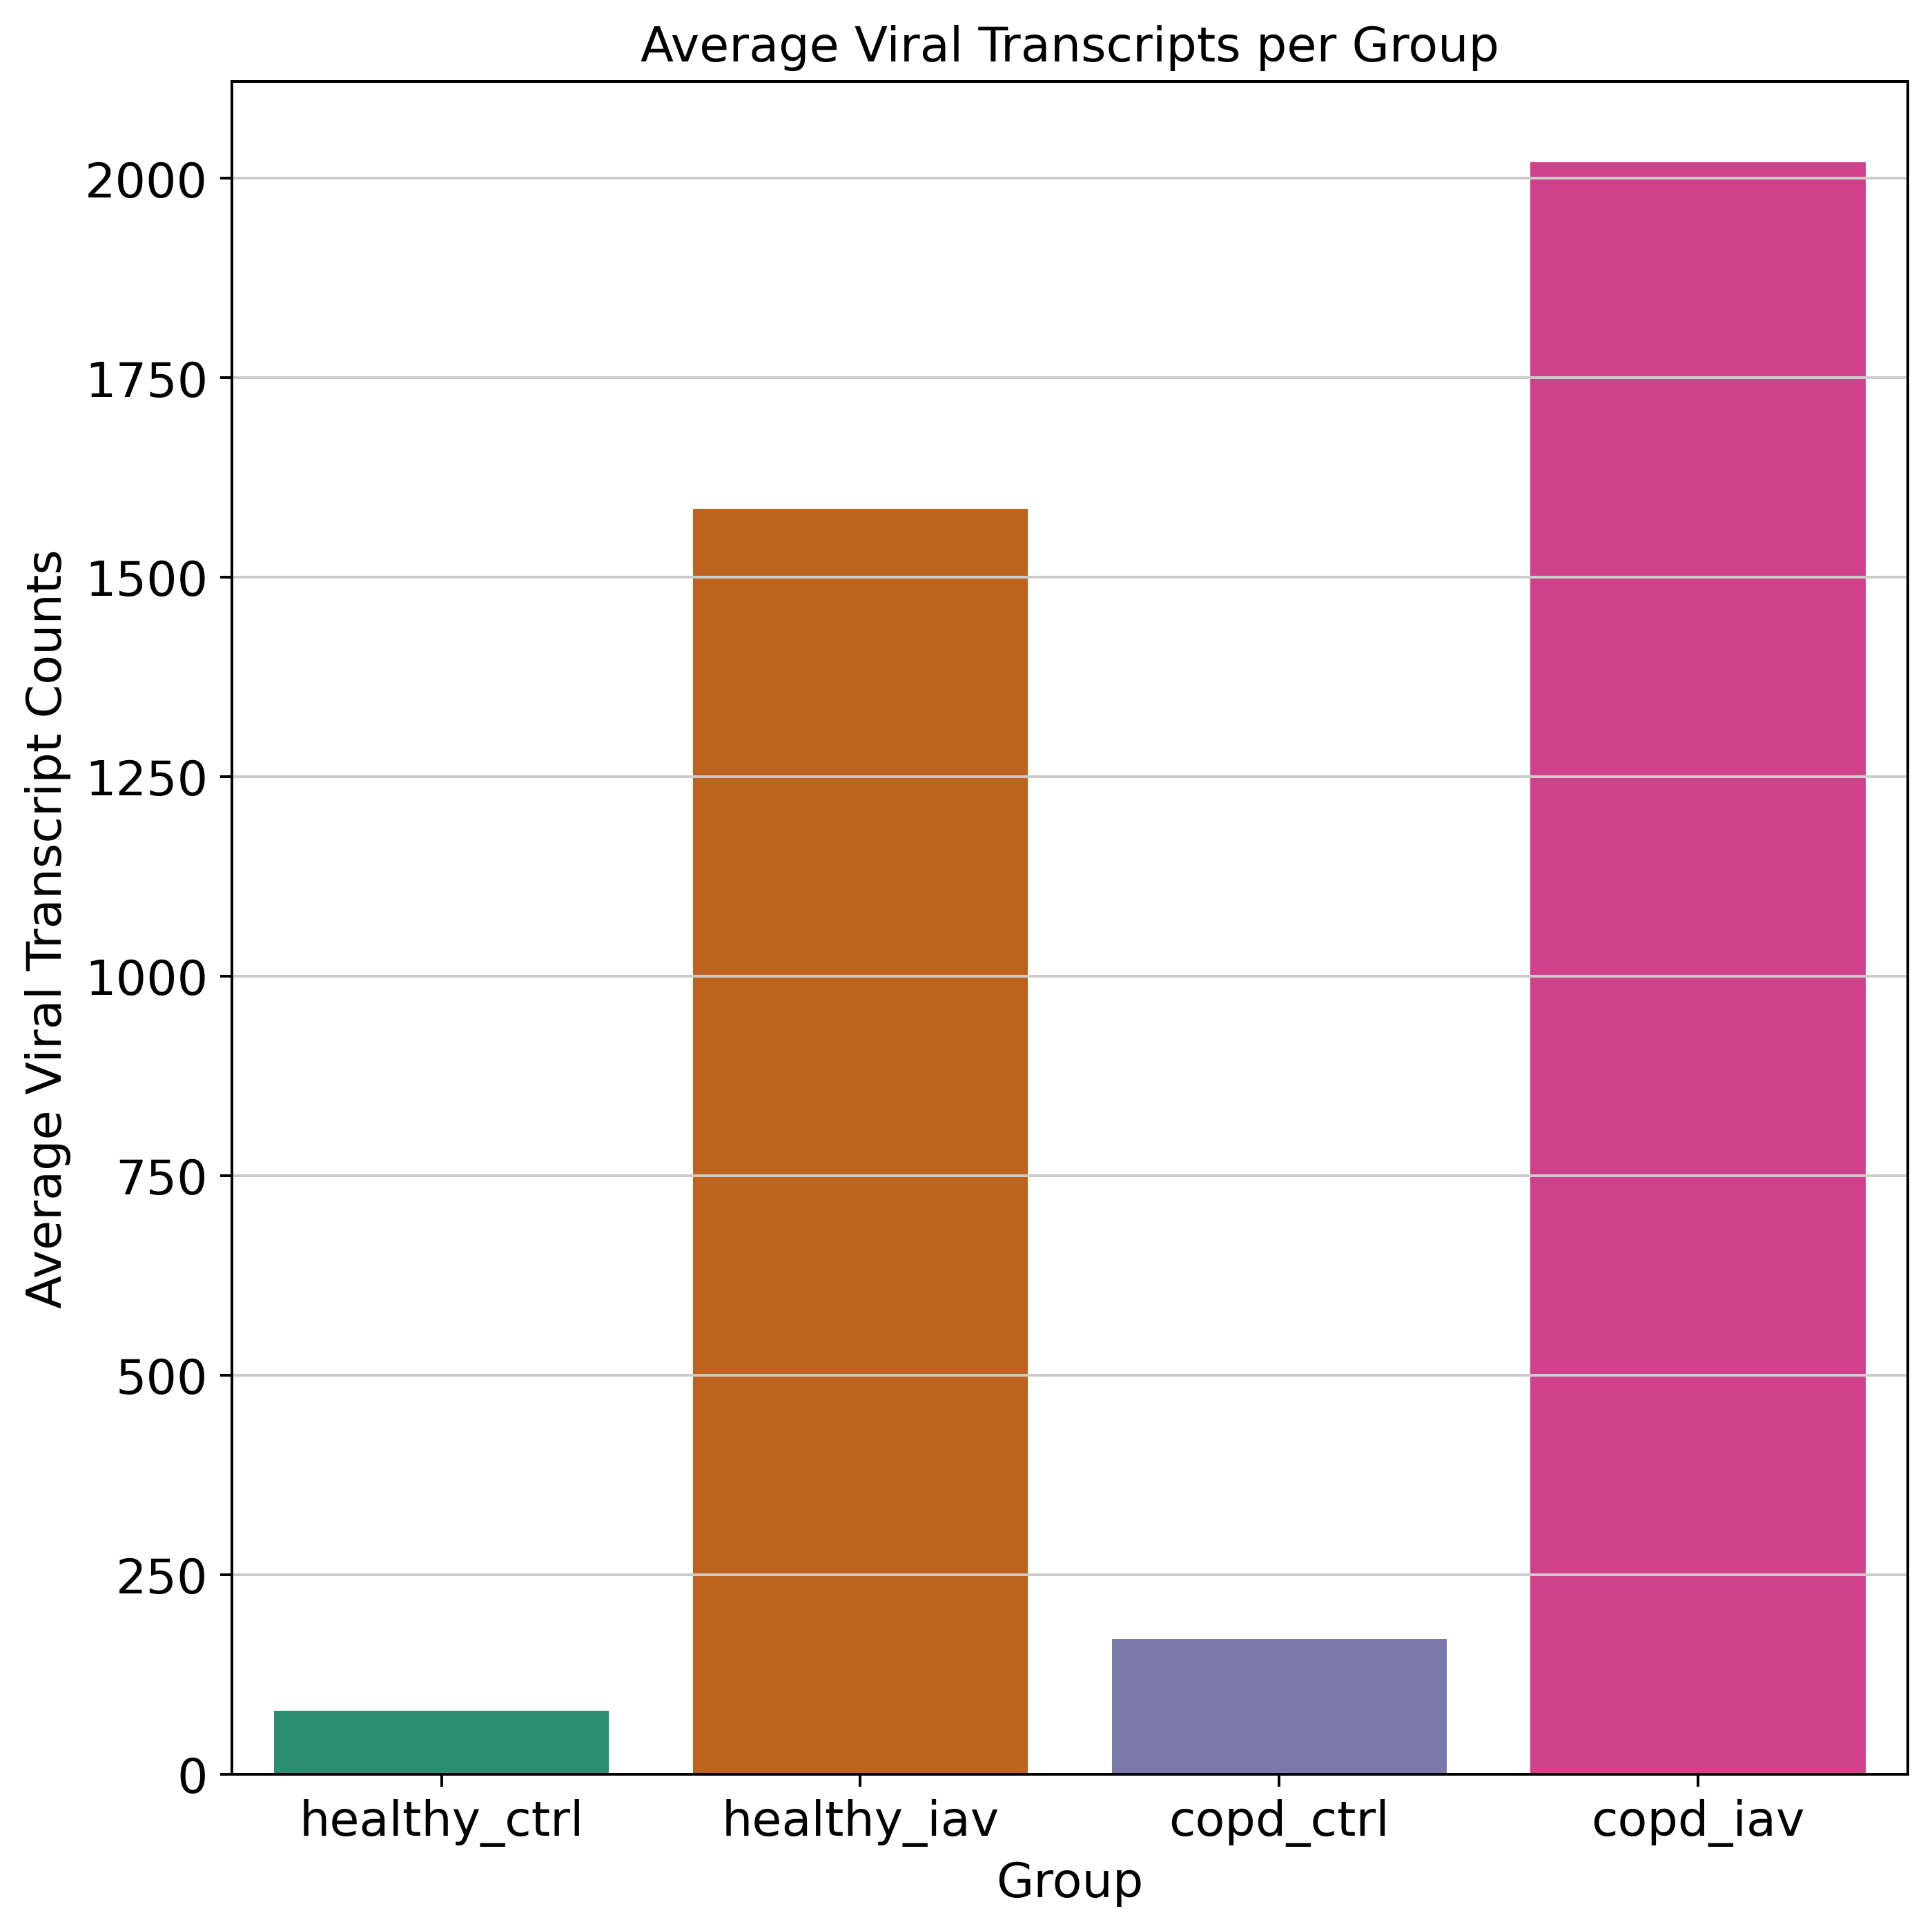

In [5]:
group_means = adata.obs.groupby('group')['viral_counts'].mean()

plt.figure(figsize = (8, 8))
sns.barplot(x = group_means.index, y = group_means.values, palette = 'Dark2')

plt.xlabel('Group')
plt.ylabel('Average Viral Transcript Counts')
plt.title('Average Viral Transcripts per Group')
plt.tight_layout()
plt.show()

/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be change

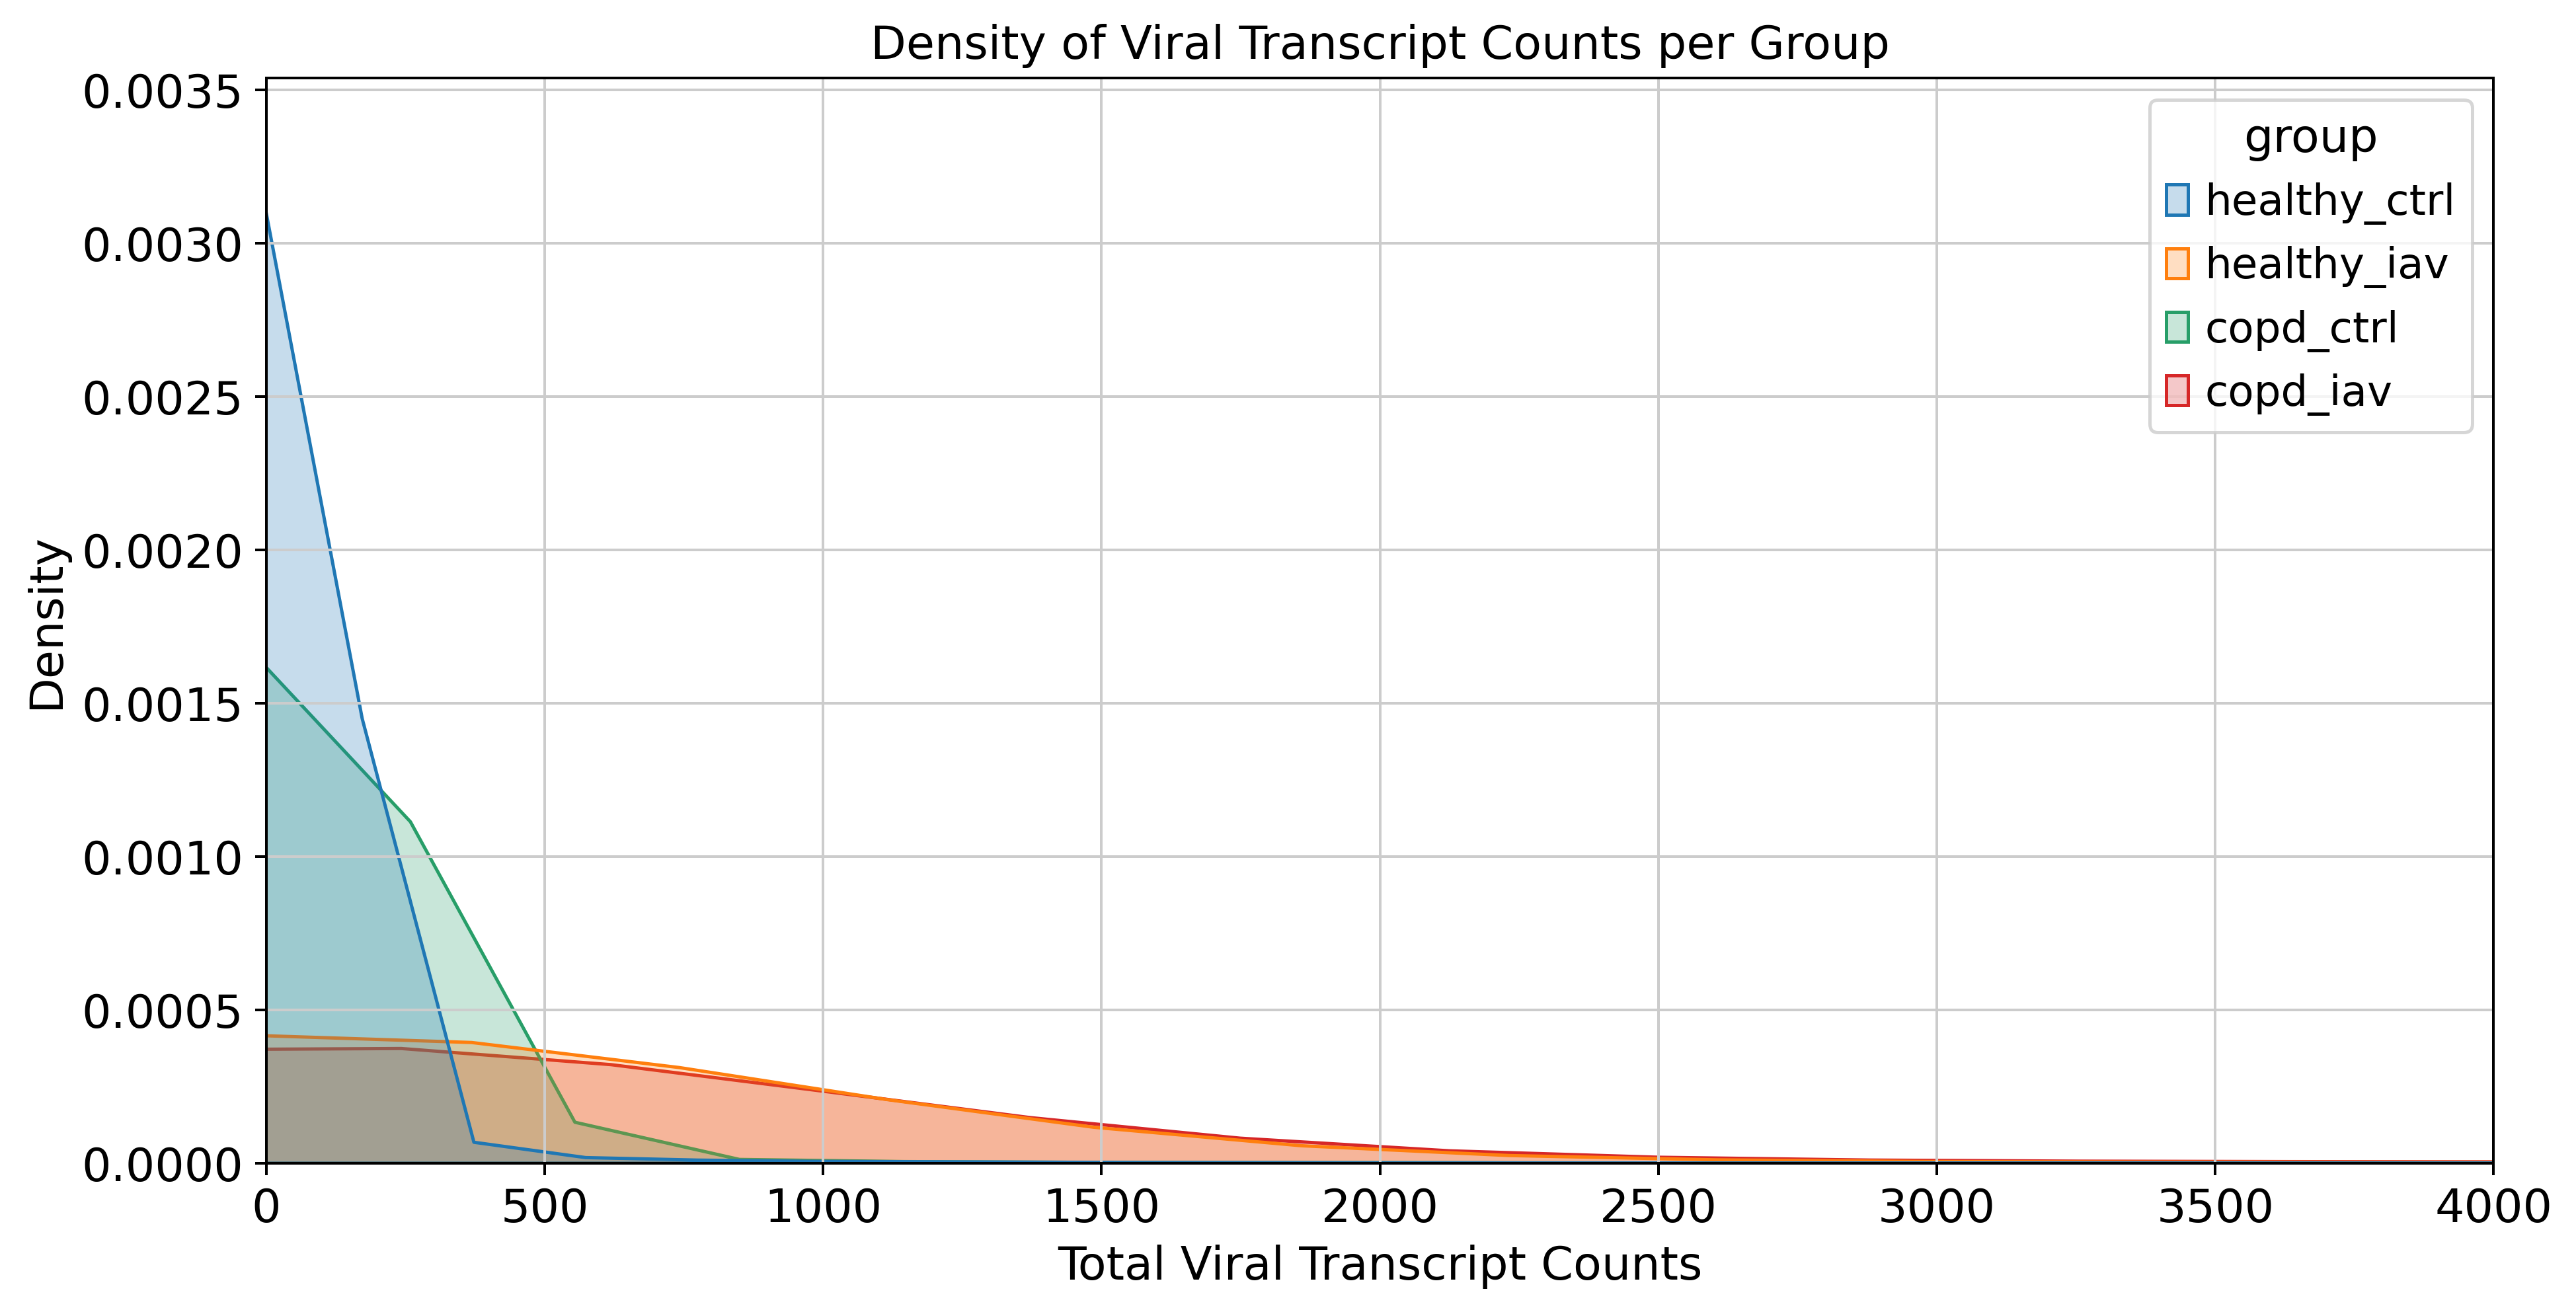

In [6]:
plt.figure(figsize = (12, 6))
sns.kdeplot(data = adata.obs, x = 'viral_counts', hue = 'group', common_norm = False, fill = True)
plt.title('Density of Viral Transcript Counts per Group')
plt.xlabel('Total Viral Transcript Counts')
plt.ylabel('Density')
plt.xlim(0, 4000)
plt.show()

### Define infected cells based on viral counts

In [7]:
adata.obs['infected_status'] = adata.obs['viral_counts'] > 1000
adata.obs['infected_status'].value_counts()

infected_status
False    92219
True      5354
Name: count, dtype: int64

In [8]:
pd.crosstab(adata.obs['infected_status'], adata.obs['group'], dropna = False)

group,healthy_ctrl,healthy_iav,copd_ctrl,copd_iav
infected_status,,,,
False,23519,20738,25944,22018
True,148,1949,317,2940


### Identify infection signature using a logistic regression model

In [9]:
X = adata.X 
y = adata.obs['infected_status']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1712)

In [11]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [12]:
important_genes_indices = log_reg.coef_.argsort()[0][-200:]
important_genes = adata.var_names[important_genes_indices]
important_genes

Index(['EPAS1', 'AFF4', 'ID2', 'CRIP2', 'CXCL10', 'CHTOP', 'GPRC5A', 'LY6E',
       'CLINT1', 'TMEM98',
       ...
       'NC_026436.1', 'CP', 'MT-ATP8', 'YWHAB', 'NC_026435.1', 'TSPAN1',
       'TNFSF10', 'NC_026431.1', 'CFL1', 'NC_026434.1'],
      dtype='object', length=200)

### Score learned signature in all cells

In [13]:
sc.tl.score_genes(adata, gene_list = important_genes.tolist(), score_name = 'infection_signature_score')
pd.crosstab(adata.obs['infection_signature_score'], adata.obs['group'], dropna = False)

computing score 'infection_signature_score'
    finished: added
    'infection_signature_score', score of gene set (adata.obs).
    293 total control genes are used. (0:00:03)


group,healthy_ctrl,healthy_iav,copd_ctrl,copd_iav
infection_signature_score,,,,
-1.348106,0,1,0,0
-1.301195,0,0,1,0
-0.875512,0,0,0,1
-0.835188,0,0,0,1
-0.599283,1,0,0,0
...,...,...,...,...
329.202167,0,1,0,0
332.041433,0,0,0,1
332.295341,0,0,0,1


/tmp/ipykernel_2921848/63905916.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_means = adata.obs.groupby('group')['infection_signature_score'].mean()
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


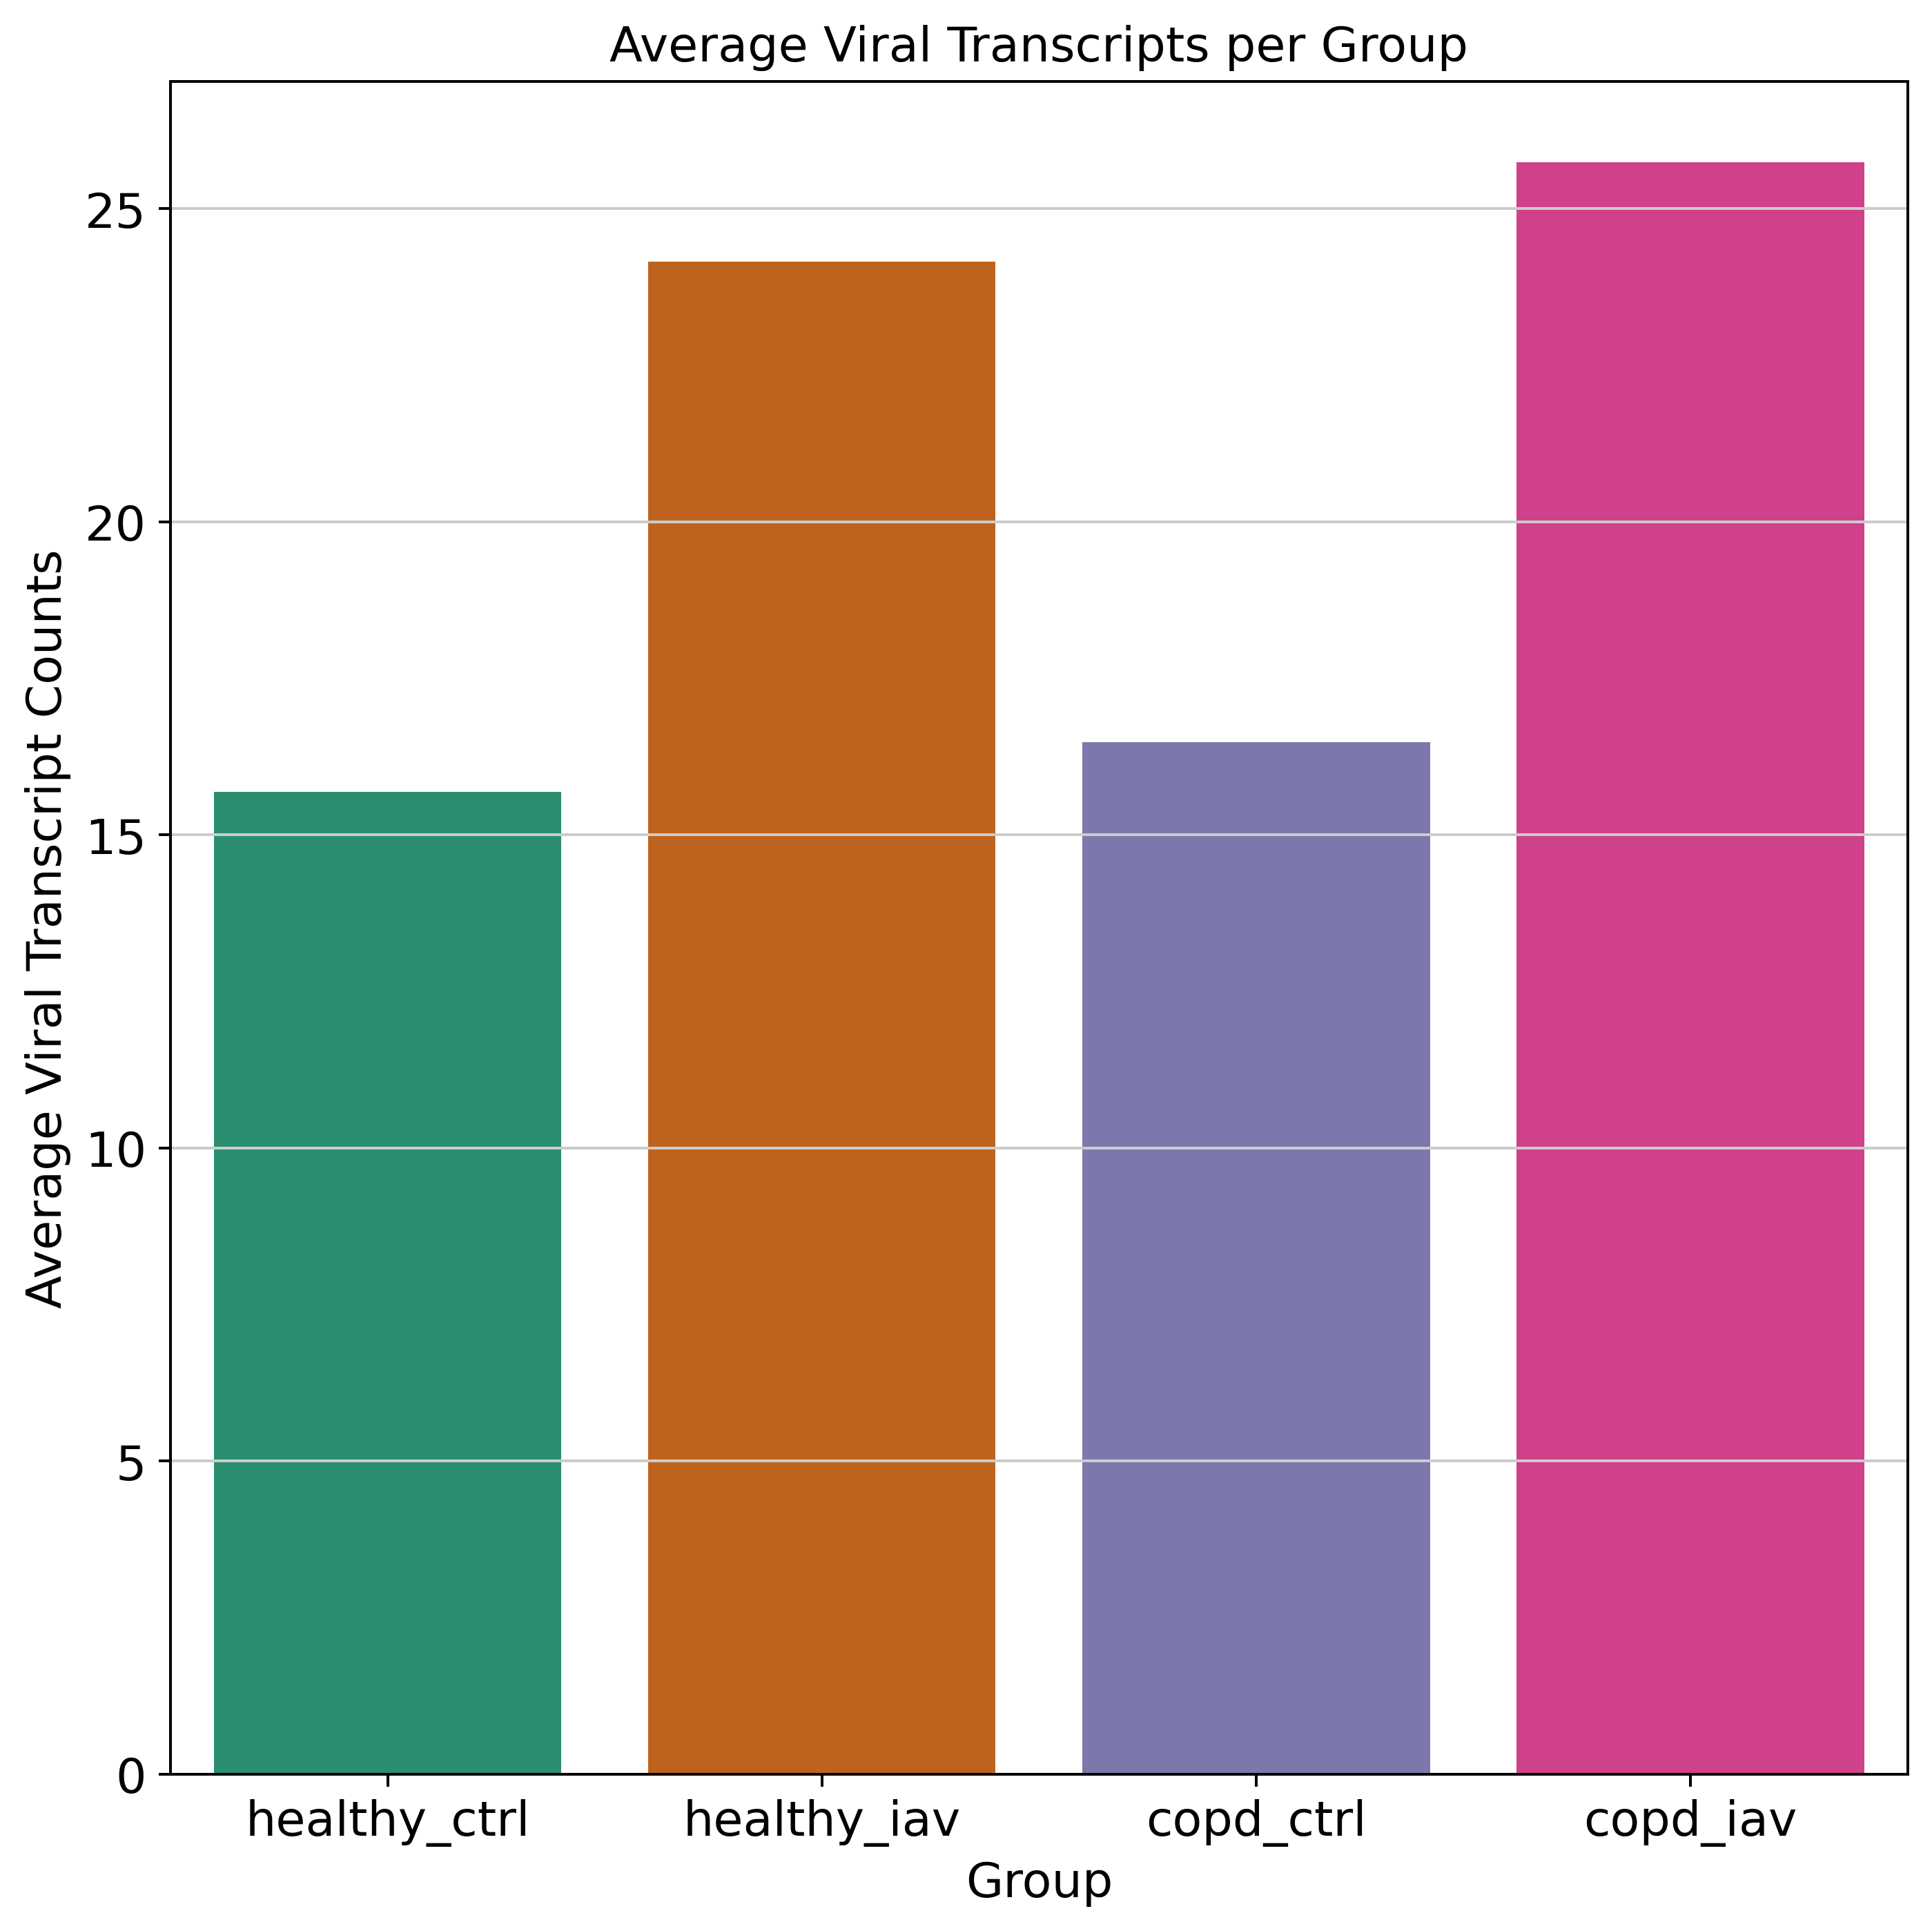

In [14]:
group_means = adata.obs.groupby('group')['infection_signature_score'].mean()

plt.figure(figsize = (8, 8))
sns.barplot(x = group_means.index, y = group_means.values, palette = 'Dark2')

plt.xlabel('Group')
plt.ylabel('Average Viral Transcript Counts')
plt.title('Average Viral Transcripts per Group')
plt.tight_layout()
plt.show()

/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be change

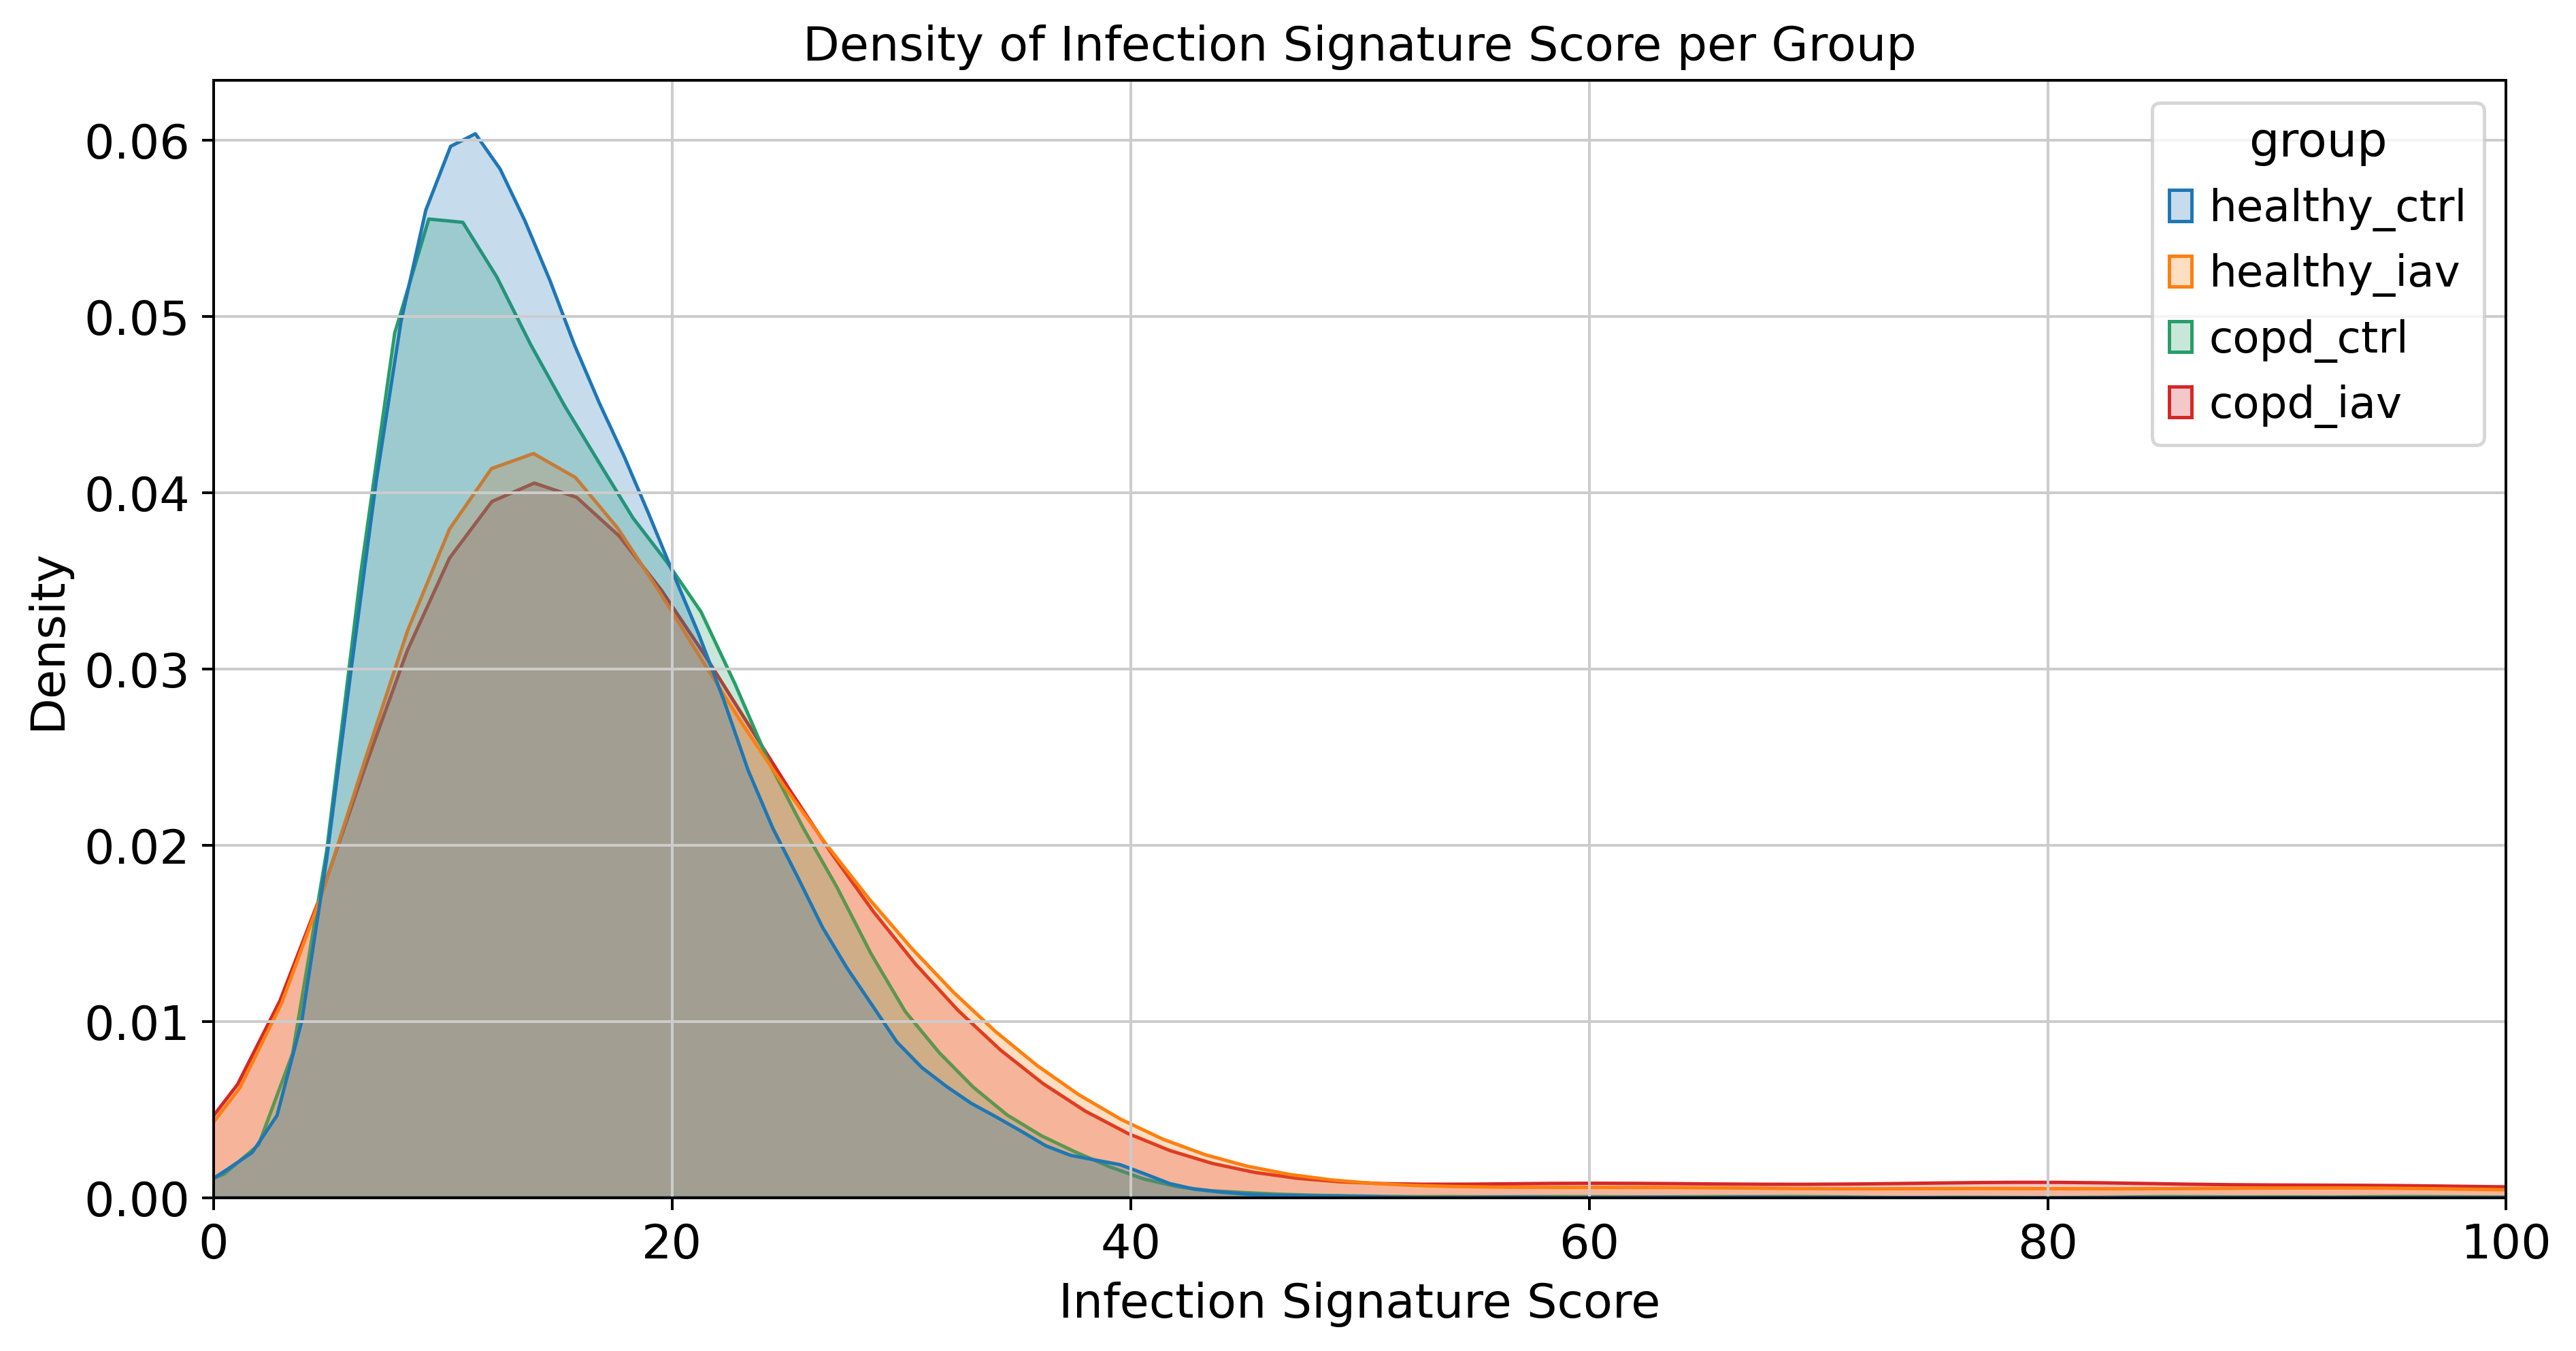

In [20]:
plt.figure(figsize = (12, 6))
sns.kdeplot(data = adata.obs, x = 'infection_signature_score', hue = 'group', common_norm = False, fill = True)
plt.title('Density of Infection Signature Score per Group')
plt.xlabel('Infection Signature Score')
plt.ylabel('Density')
plt.xlim(0, 100)
plt.show()

### Categorise cells based on viral counts and signature score

In [16]:
def classify_cells(row):
    if row['viral_counts'] > 300 and row['infection_signature_score'] > threshold_high:
        return 'Infected'
    elif row['viral_counts'] < 300 and row['infection_signature_score'] > threshold_high:
        return 'Bystander'
    elif row['viral_counts'] < 200 and row['infection_signature_score'] <= threshold_low:
        return 'Uninfected'
    else:
        return 'Bystander'

In [23]:
threshold_high = 25
threshold_low = 17
adata.obs['final_classification'] = adata.obs.apply(classify_cells, axis = 1)
pd.crosstab(adata.obs['final_classification'], adata.obs['group'], dropna = False)

group,healthy_ctrl,healthy_iav,copd_ctrl,copd_iav
final_classification,,,,
Bystander,8924,9904,10671,10722
Infected,168,1894,315,2813
Uninfected,14575,10889,15275,11423


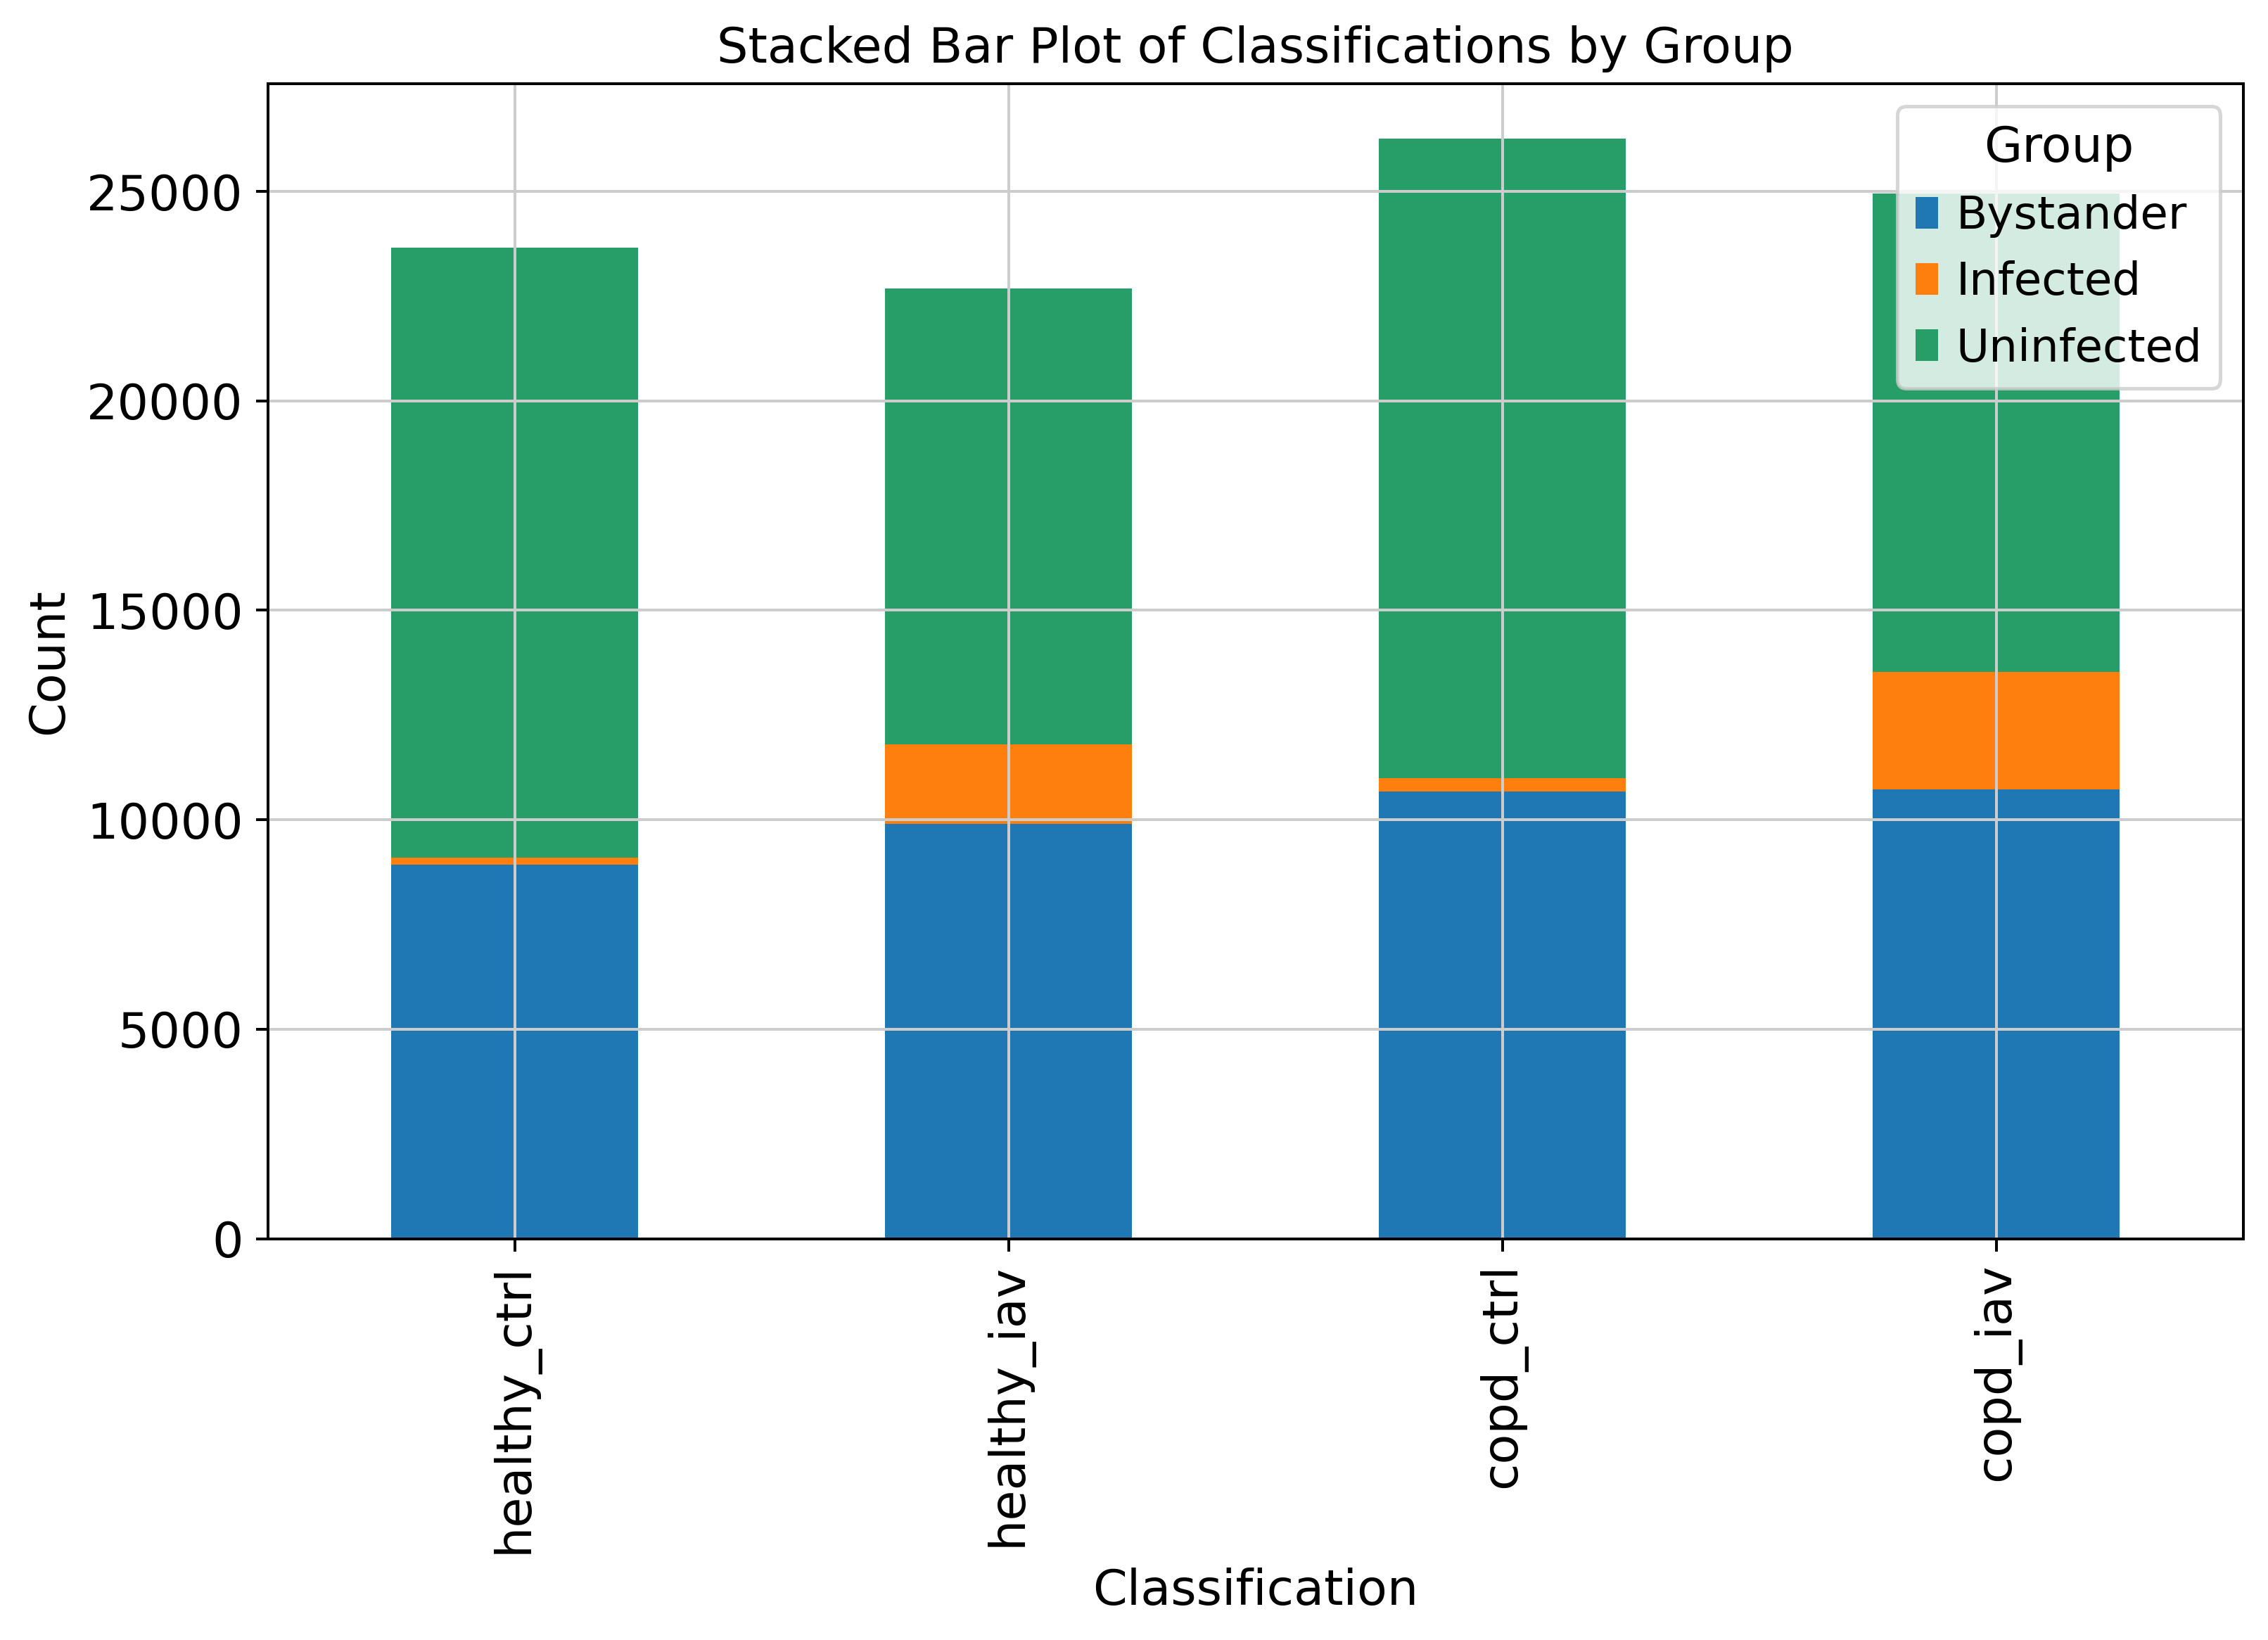

In [24]:
crosstab_df = pd.crosstab(adata.obs['group'], adata.obs['final_classification'], dropna = False)

crosstab_df.plot(kind = 'bar', stacked = True, figsize = (10, 6))
plt.title('Stacked Bar Plot of Classifications by Group')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.legend(title='Group')
plt.show()